## Returning to old DTW alignment

By aligning the full CQTs of both user audio and MIDI audio

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import sys
sys.path.append('../..')

import matplotlib.pyplot as plt
import numpy as np
from dtw import *
import scipy
import librosa

from app.core.audio.AudioData import AudioData
from app.core.audio.AudioPlayer import AudioPlayer
from app.core.midi.MidiData import MidiData
from app.core.midi.MidiPlayer import MidiPlayer
from app.core.midi.MidiSynth import MidiSynth

from app.algorithms.pitch.PYin import PYin
from app.algorithms.align.OnsetDf import UserOnsetDf, MidiOnsetDf
from app.config import AppConfig
from app.core.recording.PitchDf import PitchDf, PitchConfig
from app.algorithms.align.DTW import DTW
from app.algorithms.align.CQT import CQT

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [8]:
AUDIO_FILEPATH = '../../app/resources/audio/user_fugue2.mp3'
MIN_VIOLIN_FREQ = 196.0
SAMPLE_RATE = 44100

user_audio_data = AudioData()
user_audio_data.load_data(AUDIO_FILEPATH)
pitches, most_likely_pitches = PYin.pyin(user_audio_data.data)

Processing frame 4604/4604
Done!


In [9]:
# Create a synth with a soundfont
SOUNDFONT_FILEPATH = '../../app/resources/MuseScore_General.sf3'
midi_synth = MidiSynth(SOUNDFONT_FILEPATH)

# Load the midi file into a MidiData object
MIDI_FILEPATH = '../../app/resources/midi/fugue.mid'
midi_data = MidiData(MIDI_FILEPATH)

# Create MidiSynth/Player objects
midi_player = MidiPlayer(midi_synth)
midi_player.load_midi(midi_data)

# Also synthesize + convert MIDI to audio (for later CQT extraction)
midi_audio_data = AudioData()
midi_audio_data.load_midi_file(MIDI_FILEPATH, SOUNDFONT_FILEPATH)

# midi_player.play(start_time=0) # Play the MIDI

Loading MidiSynth...
Synth + soundfont loaded.


In [5]:
user_cqt = CQT.extract_cqt(user_audio_data.data)
midi_cqt = CQT.extract_cqt(midi_audio_data.data)

print(user_cqt.shape)
print(midi_cqt.shape)

(60, 578)
(60, 576)


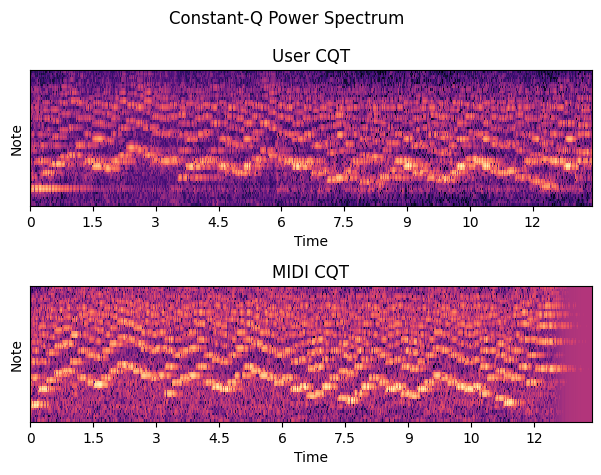

In [6]:
# Plot CQT's of both user and midi audio data
fig, axs = plt.subplots(2)
user_img = librosa.display.specshow(user_cqt, sr=SAMPLE_RATE, x_axis='time', 
                               y_axis='cqt_note', hop_length=CQT.HOP_LENGTH, ax=axs[0])

midi_img = librosa.display.specshow(midi_cqt, sr=SAMPLE_RATE, x_axis='time', 
                               y_axis='cqt_note', hop_length=CQT.HOP_LENGTH, ax=axs[1])

fig.suptitle('Constant-Q Power Spectrum')
axs[0].set_title("User CQT")
axs[1].set_title("MIDI CQT")

plt.tight_layout()
plt.show()

In [7]:
# Create distance matrix and align

def align(user_cqt, midi_cqt):
    # Create distance matrix
    distance_matrix = scipy.spatial.distance.cdist(midi_cqt.T, user_cqt.T, metric='cosine')

    # Compute the alignment
    window_args = {'window_size': 100}
    alignment = dtw(
        distance_matrix,
        keep_internals=True,
        step_pattern=symmetric1,
        window_type='sakoechiba',
        window_args=window_args
    )

    # Print some statistics (from dtw-python documentation)
    # Compute the mean alignment error
    mean_error = np.mean(np.abs(alignment.index1 - alignment.index2))

    # Print some information about the alignment
    print("DTW alignment computed.")
    print(f"Distance: {alignment.distance}") # unit = cosine distance
    print(f"Mean alignment error: {mean_error}") # unit = frames

    return alignment

alignment = align(user_cqt, midi_cqt)

DTW alignment computed.
Distance: 23.17592993072637
Mean alignment error: 22.170967741935485


In [14]:
for i1, i2 in zip(alignment.index1, alignment.index2):
    print(f"midi: {i1} user: {i2}")

midi: 0 user: 0
midi: 0 user: 1
midi: 0 user: 2
midi: 0 user: 3
midi: 1 user: 4
midi: 2 user: 5
midi: 3 user: 6
midi: 3 user: 7
midi: 4 user: 8
midi: 5 user: 9
midi: 6 user: 10
midi: 7 user: 11
midi: 8 user: 12
midi: 8 user: 13
midi: 9 user: 14
midi: 10 user: 15
midi: 11 user: 16
midi: 12 user: 17
midi: 13 user: 18
midi: 14 user: 19
midi: 15 user: 20
midi: 16 user: 21
midi: 17 user: 22
midi: 18 user: 23
midi: 19 user: 24
midi: 20 user: 25
midi: 20 user: 26
midi: 21 user: 27
midi: 22 user: 28
midi: 23 user: 29
midi: 24 user: 30
midi: 25 user: 31
midi: 26 user: 32
midi: 27 user: 33
midi: 28 user: 34
midi: 29 user: 35
midi: 30 user: 36
midi: 31 user: 37
midi: 32 user: 38
midi: 33 user: 39
midi: 34 user: 40
midi: 35 user: 41
midi: 36 user: 42
midi: 37 user: 43
midi: 38 user: 44
midi: 39 user: 45
midi: 40 user: 46
midi: 41 user: 47
midi: 42 user: 48
midi: 43 user: 49
midi: 44 user: 50
midi: 45 user: 51
midi: 46 user: 52
midi: 47 user: 53
midi: 48 user: 54
midi: 49 user: 55
midi: 50 user: 56

In [15]:
len(midi_audio_data.data) / CQT.HOP_LENGTH

575.9482421875

In [17]:
midi_data.pitch_df

,start,channel,pitch,velocity,duration,frequency
0,0.000000,0,62,100,0.185938,293.664768
1,0.187500,0,69,100,0.185938,440.000000
2,0.375001,0,73,100,0.185938,554.365262
3,0.562501,0,76,100,0.185938,659.255114
4,0.750002,0,77,100,0.185938,698.456463
...,...,...,...,...,...,...
60,11.250030,0,63,100,0.185938,311.126984
61,11.437530,0,74,100,0.185938,587.329536
62,11.625031,0,79,100,0.185938,783.990872
63,11.812532,0,72,100,0.185938,523.251131


In [8]:
import pretty_midi

aligned_midi = pretty_midi.PrettyMIDI()
VIOLIN_PROGRAM = 41
violin_instrument = pretty_midi.Instrument(program=VIOLIN_PROGRAM, is_drum=False, name='Violin')

for i, note_row in midi_data.pitch_df.iterrows():
    start_time = note_row['start']
    start_cqt_idx = int(start_time * SAMPLE_RATE / CQT.HOP_LENGTH)
    
    align_idx = (np.abs(alignment.index1 - start_cqt_idx)).argmin()
    warped_start_time = alignment.index2[align_idx] * CQT.HOP_LENGTH / SAMPLE_RATE

    # Computing the warped end time
    if i == len(midi_data.pitch_df) - 1:
        warped_end_time = alignment.index2[-1] * CQT.HOP_LENGTH / SAMPLE_RATE
    else:
        next_start_time = midi_data.pitch_df.iloc[i+1]['start']
        next_cqt_idx = int(next_start_time * SAMPLE_RATE / CQT.HOP_LENGTH)
        next_align_idx = (np.abs(alignment.index1 - next_cqt_idx)).argmin()
        warped_end_time = alignment.index2[next_align_idx] * CQT.HOP_LENGTH / SAMPLE_RATE

    velocity = int(note_row['velocity'])
    pitch = int(note_row['pitch'])
    note = pretty_midi.Note(velocity=velocity, pitch=pitch, start=warped_start_time, end=warped_end_time)
    violin_instrument.notes.append(note)

    print(f"cqt_idx{start_cqt_idx} is at index {align_idx} in alignment")

aligned_midi.instruments.append(violin_instrument)
aligned_midi.write("aligned.mid")

cqt_idx0 is at index 0 in alignment
cqt_idx8 is at index 13 in alignment
cqt_idx16 is at index 21 in alignment
cqt_idx24 is at index 30 in alignment
cqt_idx32 is at index 38 in alignment
cqt_idx40 is at index 46 in alignment
cqt_idx48 is at index 54 in alignment
cqt_idx56 is at index 64 in alignment
cqt_idx64 is at index 73 in alignment
cqt_idx72 is at index 82 in alignment
cqt_idx80 is at index 90 in alignment
cqt_idx88 is at index 98 in alignment
cqt_idx96 is at index 106 in alignment
cqt_idx104 is at index 115 in alignment
cqt_idx113 is at index 125 in alignment
cqt_idx121 is at index 133 in alignment
cqt_idx129 is at index 142 in alignment
cqt_idx137 is at index 151 in alignment
cqt_idx145 is at index 159 in alignment
cqt_idx153 is at index 167 in alignment
cqt_idx161 is at index 176 in alignment
cqt_idx169 is at index 184 in alignment
cqt_idx177 is at index 192 in alignment
cqt_idx185 is at index 201 in alignment
cqt_idx193 is at index 210 in alignment
cqt_idx201 is at index 218 i

In [9]:
# Create a synth with a soundfont
SOUNDFONT_FILEPATH = '../../app/resources/MuseScore_General.sf3'
midi_synth = MidiSynth(SOUNDFONT_FILEPATH)

# Load the midi file into a MidiData object
ALIGNED_MIDI_FILEPATH = 'aligned.mid'
aligned_midi_data = MidiData(ALIGNED_MIDI_FILEPATH)

# Create MidiSynth/Player objects
midi_player = MidiPlayer(midi_synth)
midi_player.load_midi(aligned_midi_data)

midi_player.play(start_time=0) # Play the MIDI

Loading MidiSynth...
Synth + soundfont loaded.


In [10]:
aligned_midi_data.pitch_df

,start,channel,pitch,velocity,duration,frequency
0,0.000000,0,62,100,0.302273,293.664768
1,0.302273,0,69,100,0.186364,440.000000
2,0.488636,0,73,100,0.209091,554.365262
3,0.697727,0,76,100,0.184091,659.255114
4,0.881818,0,77,100,0.186364,698.456463
...,...,...,...,...,...,...
60,12.213636,0,63,100,0.186364,311.126984
61,12.400000,0,74,100,0.184091,587.329536
62,12.584091,0,79,100,0.163636,783.990872
63,12.747727,0,72,100,0.186364,523.251131


In [11]:
pitch_config = PitchConfig( # Defines resolution of pitch bins
    bins_per_semitone=10, tuning=440.0, fmin=196, fmax=5000
)
user_pitch_df = PitchDf(user_audio_data, pitch_config, pitches)
user_onset_df = UserOnsetDf(user_audio_data, pitches, user_pitch_df)
user_onset_df.onset_df

Detecting onsets... Done!
Detecting pitch changes with rolling median window_size=30 and threshold=0.6... Done!


,time,pitch_diff,onset,cqt_norm
0,0.000000,True,True,"[-0.080838166, -0.0668917, -0.064405546, -0.05..."
1,0.095782,True,False,"[-0.058326993, -0.054367118, -0.04979177, -0.0..."
2,0.156735,True,False,"[-0.061443117, -0.057020873, -0.05249979, -0.0..."
3,0.211882,True,True,"[-0.09267126, -0.08816784, -0.0827672, -0.0738..."
4,0.269932,True,True,"[-0.06905533, -0.064700454, -0.058468398, -0.0..."
...,...,...,...,...
231,13.142494,True,False,"[-0.13636264, -0.13234997, -0.13260415, -0.134..."
232,13.194739,True,False,"[-0.14470737, -0.13311756, -0.13077247, -0.141..."
233,13.246984,True,False,"[-0.106660314, -0.10152327, -0.10050003, -0.10..."
234,13.299229,True,False,"[-0.13542737, -0.12484761, -0.12350919, -0.127..."


In [23]:
closest_onsets = []
for onset_row in aligned_midi_data.pitch_df.itertuples():
    start_time = onset_row.start

    # Absolute value of start_time - each onset time in user_onset_df
    differences = np.abs(user_onset_df.onset_df['time'] - start_time)

    # Find the minimum difference and its index if it is within the 0.1-second threshold
    min_diff_idx = differences.idxmin()
    min_diff = differences[min_diff_idx]

    if min_diff <= 0.1:
        # If a match is within 0.1 seconds, take the closest onset as the new onset
        closest_onset = user_onset_df.onset_df.loc[min_diff_idx, 'time']
    else:
        # If no onset is within 0.1 seconds, use the original onset as-is
        closest_onset = start_time

    # Append the closest onset to the list
    closest_onsets.append(closest_onset)

better_align_df = aligned_midi_data.pitch_df.copy()
better_align_df['closest_onset'] = closest_onsets
better_align_df

,start,channel,pitch,velocity,duration,frequency,closest_onset
0,0.000000,0,62,100,0.302273,293.664768,0.000000
1,0.302273,0,69,100,0.186364,440.000000,0.269932
2,0.488636,0,73,100,0.209091,554.365262,0.461497
3,0.697727,0,76,100,0.184091,659.255114,0.714014
4,0.881818,0,77,100,0.186364,698.456463,0.885261
...,...,...,...,...,...,...,...
60,12.213636,0,63,100,0.186364,311.126984,12.207891
61,12.400000,0,74,100,0.184091,587.329536,12.382041
62,12.584091,0,79,100,0.163636,783.990872,12.596825
63,12.747727,0,72,100,0.186364,523.251131,12.759365


In [24]:
import pretty_midi

aligned_midi2 = pretty_midi.PrettyMIDI()
VIOLIN_PROGRAM = 41
violin_instrument2 = pretty_midi.Instrument(program=VIOLIN_PROGRAM, is_drum=False, name='Violin')

for i, note_row in better_align_df.iterrows():
    start_time = note_row['start']
    duration = note_row['duration']
    velocity = int(note_row['velocity'])
    pitch = int(note_row['pitch'])
    note = pretty_midi.Note(velocity=velocity, pitch=pitch, start=start_time, end=start_time+duration)
    violin_instrument2.notes.append(note)

aligned_midi2.instruments.append(violin_instrument2)
aligned_midi2.write("aligned2.mid")

In [25]:
# Create a synth with a soundfont
SOUNDFONT_FILEPATH = '../../app/resources/MuseScore_General.sf3'
midi_synth = MidiSynth(SOUNDFONT_FILEPATH)

# Load the midi file into a MidiData object
ALIGNED_MIDI_FILEPATH = 'aligned2.mid'
aligned_midi_data = MidiData(ALIGNED_MIDI_FILEPATH)

# Create MidiSynth/Player objects
midi_player = MidiPlayer(midi_synth)
midi_player.load_midi(aligned_midi_data)

midi_player.play(start_time=0) # Play the MIDI

Loading MidiSynth...
Synth + soundfont loaded.


In [26]:
# View the pitch estimates in the app
import sys
sys.path.append('..')

from app.ui.plots.PitchPlot import RunPitchPlot
from app.core.midi.MidiData import MidiData
from PyQt6.QtWidgets import QApplication
from PyQt6.QtCore import QCoreApplication


if __name__ == '__main__':
    if not QCoreApplication.instance():
        app = QApplication(sys.argv)
    else:
        app = QCoreApplication.instance()

    ALIGNED_MIDI_FILEPATH = 'aligned.mid'
    aligned_midi_data = MidiData(ALIGNED_MIDI_FILEPATH)

    # pitchplot = RunPitchPlot(
    #     app, midi_data=midi_data, pitches=most_likely_pitches, onsets=user_onset2_df.onset_df, align_df=align_df2
    # )
    pitchplot = RunPitchPlot(
        app, midi_data=aligned_midi_data, pitches=pitches
    )

Plotting pitches...
Done!


qt.pointer.dispatch: skipping QEventPoint(id=1 ts=0 pos=0,0 scn=881.841,484.669 gbl=881.841,484.669 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-881.841,-484.669 last=-881.841,-484.669 Δ 881.841,484.669) : no target window
qt.pointer.dispatch: skipping QEventPoint(id=1 ts=0 pos=0,0 scn=504.263,465.524 gbl=504.263,465.524 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-504.263,-465.524 last=-504.263,-465.524 Δ 504.263,465.524) : no target window


In [5]:
import numpy as np

def levenshtein(s1, s2):
    """
    Compute the Levenshtein distance between two strings.

    Args:
        s1 (str): The first string.
        s2 (str): The second string.

    Returns:
        int: The Levenshtein distance between the two strings.
    """
    # init dynamic programming matrix
    n, m = len(s1), len(s2)
    mat = np.zeros((n+1, m+1), dtype=int) 

    
    # init first row / col
    # compares empty string to s1/s2 substring
    mat[:, 0] = np.arange(n+1)
    mat[0, :] = np.arange(m+1)

    # dynamic programming: fill in matrix
    for i in range(1, n+1):
        for j in range(1, m+1):
            # chars match
            if s1[i-1] == s2[j-1]:
                mat[i, j] = mat[i-1, j-1] # take upper left diag
            else:
                mat[i, j] = min(
                    mat[i-1, j] + 1, # deletion
                    mat[i, j-1] + 1, # insertion
                    mat[i-1, j-1] + 1 # substitution
                )
    return mat[n, m]

s1 = "kitten"
s2 = "kritn"

distance = levenshtein(s1, s2)
print(f"Levenshtein distance between '{s1}' and '{s2}': {distance}")

Levenshtein distance between 'kitten' and 'kritn': 3
